In [102]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import gc
import pandas_profiling as ppf

ModuleNotFoundError: No module named 'pandas_profiling'

In [92]:
dir_path = './'
file_train = 'train.csv'
file_questions = 'questions.csv'
file_lectures = 'lectures.csv'

In [93]:
nrows = 100 * 10000

In [94]:
train = pd.read_csv(
                    dir_path + file_train, 
                    nrows=nrows, 
                    usecols=['row_id', 'timestamp', 'user_id', 'content_id', 
                             'content_type_id', 'task_container_id', 'answered_correctly',
                            'prior_question_elapsed_time','prior_question_had_explanation'],
                    dtype={
                            'row_id': 'int64',
                            'timestamp': 'int64',
                            'user_id': 'int32',
                            'content_id': 'int16',
                            'content_type_id': 'int8',
                            'task_container_id': 'int8',
                            'answered_correctly': 'int8',
                            'prior_question_elapsed_time': 'float32',
                            'prior_question_had_explanation': 'str'
                        }
                   )

lectures = pd.read_csv(
                       dir_path + file_lectures, 
                       usecols=['lecture_id','tag','part','type_of'], 
                       nrows=nrows,
                       dtype={
                           'lecture_id': 'int16',
                           'tag': 'int16',
                           'part': 'int8',
                           'type_of': 'str'
                       }
                    )

questions = pd.read_csv(
                        dir_path + file_questions, 
                        nrows=nrows,
                        usecols=['question_id','bundle_id','part','tags'], 
                        dtype={
                           'question_id': 'int16',
                           'bundle_id': 'int16',
                           'part': 'int8',
                           'tags': 'str'
                       }
                    )

In [8]:
# 数据处理
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].map({'True':1,'False':0}).fillna(-1).astype(np.int8)
lectures['type_of'] = lectures['type_of'].map({'concept':0,'intention':1,'solving question':2,'starter':3}).fillna(-1).astype(np.int8)
questions['tags'] = questions['tags'].map(lambda x:len(str(x).split(' ')))

In [101]:
import Counter
min = questions.min(0)
min_matrix = np.tile(min,(questions.shape[0],1))
min_matrix

ModuleNotFoundError: No module named 'Counter'

In [9]:
questions.head()

,question_id,bundle_id,part,tags
0,0,0,1,4
1,1,1,1,3
2,2,2,1,4
3,3,3,1,4
4,4,4,1,4


In [10]:
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,0
1,100,70,1,0
2,185,45,6,0
3,192,79,5,2
4,317,156,5,2


In [12]:
# 压缩内存
max_num = 1000
train = train.groupby(['user_id']).tail(max_num)

In [13]:
# 切分数据
train_lectures = train[train['content_type_id']==1]
train_questions = train[train['content_type_id']==0]

In [14]:
del train
gc.collect()

15192

In [17]:
#关联数据
train_lectures_info = pd.merge(
        left=train_lectures,
        right=lectures,
        how='left',
        left_on='content_id',
        right_on='lecture_id'
    )

train_questions_info = pd.merge(
        left=train_questions,
        right=questions,
        how='left',
        left_on='content_id',
        right_on='question_id'
        )

In [18]:
del train_lectures
del train_questions
gc.collect()

7976

In [19]:
train_questions_info.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,part,tags
0,0,0,115,5692,0,1,1,NaN,-1,5692,5692,5,1
1,1,56943,115,5716,0,2,1,37000.0,0,5716,5716,5,1
2,2,118363,115,128,0,0,1,55000.0,0,128,128,1,3
3,3,131167,115,7860,0,3,1,19000.0,0,7860,7860,1,3
4,4,137965,115,7922,0,4,1,11000.0,0,7922,7922,1,3


In [44]:
train_lectures_info.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,lecture_id,tag,part,type_of
0,89,653762,2746,6808,1,14,-1,NaN,0,6808,129,2,1
1,117,10183847,5382,16736,1,21,-1,NaN,0,16736,40,1,0
2,212,1424348597,5382,30207,1,104,-1,NaN,0,30207,43,5,0
3,216,1425557777,5382,18545,1,121,-1,NaN,0,18545,58,5,0
4,295,405813029,8623,10540,1,59,-1,NaN,0,10540,99,1,0


In [39]:
# 提取特征函数
# 文献课程类函数
def get_lecture_basic_features__user(train_lectures_info):
    gb_columns = ['user_id']
    gb_suffixes = 'lecture_'+'_'.join(gb_columns)
    
    agg_func = {
        'lecture_id': [np.size], #,np.sum],
        'task_container_id': [lambda x: len(set(x))],
        'tag': [lambda x: len(set(x))],

        # part 展开
        'part': [lambda x: len(set(x))],

        # type_of 展开
        'type_of': [lambda x: len(set(x))],
    }
    columns = [
           gb_suffixes+'_size_lecture_id', 
#            gb_suffixes+'_size_lecture_id_sum', 
           gb_suffixes+'_unique_task_container_id',
           gb_suffixes+'_unique_tag',
           gb_suffixes+'_unique_part',
           gb_suffixes+'_unique_type_of'
          ]  
    train_lectures_info__user_f = train_lectures_info.\
                                groupby(gb_columns).\
                                agg(agg_func).\
                                reset_index()
    
    train_lectures_info__user_f.columns = gb_columns + columns
    return train_lectures_info__user_f

def get_lecture_basic_features__user_tag(train_lectures_info):
    gb_columns = ['user_id','tag']
    gb_suffixes = 'lecture_'+'_'.join(gb_columns)
    agg_func = {
        'lecture_id': [np.size],
        'task_container_id': [lambda x: len(set(x))],
        'tag': [lambda x: len(set(x))],

        # part 展开
        'part': [lambda x: len(set(x))],
    }
    columns = [
               gb_suffixes+'_size_lecture_id', 
               gb_suffixes+'_unique_task_container_id',
               gb_suffixes+'_unique_tag',
               gb_suffixes+'_unique_part'
              ]    
    train_lectures_info__user_tag_f = train_lectures_info.\
                                    groupby(gb_columns).\
                                    agg(agg_func).\
                                    reset_index()
    train_lectures_info__user_tag_f.columns = gb_columns + columns    
    return train_lectures_info__user_tag_f

# 问答类函数
def get_questions_basic_features__user(train_questions_info):
    gb_columns = ['user_id']
    gb_suffixes = 'question_'+'_'.join(gb_columns)
    agg_func = {
        'answered_correctly': [np.mean,np.sum,np.std],

        'question_id': [np.size],
        'task_container_id': [lambda x: len(set(x))],

        'prior_question_elapsed_time': [np.mean,np.max,np.min],

        'prior_question_had_explanation': [lambda x: len(set(x))],

        'bundle_id': [lambda x: len(set(x))],

        # part 展开
        'part': [lambda x: len(set(x))],
        'tags': [lambda x: len(set(x))],
    }
    columns = [
               gb_suffixes+'_answered_correctly_mean',
               gb_suffixes+'_answered_correctly_max',
               gb_suffixes+'_answered_correctly_min',

               gb_suffixes+'_size_question_id', 
               gb_suffixes+'_unique_task_container_id',
               gb_suffixes+'_prior_question_elapsed_time_mean',
               gb_suffixes+'_prior_question_elapsed_time_max',
               gb_suffixes+'_prior_question_elapsed_time_min',

               gb_suffixes+'_unique_prior_question_had_explanation',

               gb_suffixes+'_unique_bundle_id',
               gb_suffixes+'_unique_part',
               gb_suffixes+'_unique_tags',
              ]
    train_questions_info__user_f = train_questions_info.\
                                    groupby(gb_columns).\
                                    agg(agg_func).\
                                    reset_index()
    train_questions_info__user_f.columns = gb_columns + columns    

    return train_questions_info__user_f

def get_questions_basic_features__user_part(train_questions_info):
    gb_columns = ['user_id','part']
    gb_suffixes = 'question_'+'_'.join(gb_columns)
    agg_func = {
        'answered_correctly': [np.mean,np.sum,np.std],

        'question_id': [np.size],
        'task_container_id': [lambda x: len(set(x))],

        'prior_question_elapsed_time': [np.mean,np.max,np.min],

        'prior_question_had_explanation': [lambda x: len(set(x))],

        'bundle_id': [lambda x: len(set(x))],

        # part 展开
        'part': [lambda x: len(set(x))],
        'tags': [lambda x: len(set(x))],
    }
    columns = [
               gb_suffixes+'_answered_correctly_mean',
               gb_suffixes+'_answered_correctly_max',
               gb_suffixes+'_answered_correctly_min',

               gb_suffixes+'_size_question_id', 
               gb_suffixes+'_unique_task_container_id',
               gb_suffixes+'_prior_question_elapsed_time_mean',
               gb_suffixes+'_prior_question_elapsed_time_max',
               gb_suffixes+'_prior_question_elapsed_time_min',

               gb_suffixes+'_unique_prior_question_had_explanation',

               gb_suffixes+'_unique_bundle_id',
               gb_suffixes+'_unique_part',
               gb_suffixes+'_unique_tags',
              ]    
    train_questions_info__user_part_f = train_questions_info.\
                                    groupby(gb_columns).\
                                    agg(agg_func).\
                                    reset_index()
    train_questions_info__user_part_f.columns = gb_columns + columns    

    return train_questions_info__user_part_f

def get_questions_basic_features__content(train_questions_info):
    gb_columns = ['content_id']
    gb_suffixes = 'question_'+'_'.join(gb_columns)
    agg_func = {
        'answered_correctly': [np.mean,np.sum,np.std],

        'user_id': [np.size],

        'prior_question_elapsed_time': [np.mean,np.max,np.min],

        'prior_question_had_explanation': [lambda x: len(set(x))],
    }
    columns = [
               gb_suffixes+'_answered_correctly_mean',
               gb_suffixes+'_answered_correctly_max',
               gb_suffixes+'_answered_correctly_min',

               gb_suffixes+'_size_user_id', 
               gb_suffixes+'_prior_question_elapsed_time_mean',
               gb_suffixes+'_prior_question_elapsed_time_max',
               gb_suffixes+'_prior_question_elapsed_time_min',

               gb_suffixes+'_unique_prior_question_had_explanation',
              ]    
    
    train_questions_info__user_content_f = train_questions_info.\
                                    groupby(gb_columns).\
                                    agg(agg_func).\
                                    reset_index()
    train_questions_info__user_content_f.columns = gb_columns + columns
    
    return train_questions_info__user_content_f

In [40]:
# 预测用户
test_lectures_info__user_f = get_lecture_basic_features__user(train_lectures_info)
# test_lectures_info__user_tag_f = get_lecture_basic_features__user_tag(train_lectures_info)
test_questions_info__user_f = get_questions_basic_features__user(train_questions_info)
# test_questions_info__user_part_f = get_questions_basic_features__user_part(train_questions_info)
test_questions_info__user_content_f = get_questions_basic_features__content(train_questions_info)

In [58]:
# 验证数据
valid_data = pd.DataFrame()

for i in range(6):
    
    # 获取训练标签数据
    last_records = train_questions_info.drop_duplicates('user_id', keep='last')
    
    # 获取训练标签以前的数据
    map__last_records__user_row = dict(zip(last_records['user_id'],last_records['row_id']))
    
    train_questions_info['filter_row'] = train_questions_info['user_id'].map(map__last_records__user_row)
    train_lectures_info['filter_row'] = train_lectures_info['user_id'].map(map__last_records__user_row)

    train_questions_info = train_questions_info[train_questions_info['row_id']<train_questions_info['filter_row']]
    train_lectures_info = train_lectures_info[train_lectures_info['row_id']<train_lectures_info['filter_row']]
    
    # 获取特征
    train_lectures_info__user_f = get_lecture_basic_features__user(train_lectures_info)
    # train_lectures_info__user_tag_f = get_lecture_basic_features__user_tag(train_lectures_info)
    train_questions_info__user_f = get_questions_basic_features__user(train_questions_info)
    # train_questions_info__user_part_f = get_questions_basic_features__user_part(train_questions_info)
    train_questions_info__user_content_f = get_questions_basic_features__content(train_questions_info)

    last_records = last_records.merge(train_lectures_info__user_f,on=['user_id'],how='left')
    last_records = last_records.merge(train_questions_info__user_f,on=['user_id'],how='left')
    last_records = last_records.merge(train_questions_info__user_content_f,on=['content_id'],how='left')
    
    # 特征加入训练集
    valid_data = valid_data.append(last_records)
    print(len(valid_data))

3549


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


6943
10281
13557
16768
19910


In [59]:
# 训练数据
train_data = pd.DataFrame()

for i in range(10):
    
    # 获取训练标签数据
    last_records = train_questions_info.drop_duplicates('user_id', keep='last')
    
    # 获取训练标签以前的数据
    map__last_records__user_row = dict(zip(last_records['user_id'],last_records['row_id']))
    
    train_questions_info['filter_row'] = train_questions_info['user_id'].map(map__last_records__user_row)
    train_lectures_info['filter_row'] = train_lectures_info['user_id'].map(map__last_records__user_row)

    train_questions_info = train_questions_info[train_questions_info['row_id']<train_questions_info['filter_row']]
    train_lectures_info = train_lectures_info[train_lectures_info['row_id']<train_lectures_info['filter_row']]
    
    # 获取特征
    train_lectures_info__user_f = get_lecture_basic_features__user(train_lectures_info)
    # train_lectures_info__user_tag_f = get_lecture_basic_features__user_tag(train_lectures_info)
    train_questions_info__user_f = get_questions_basic_features__user(train_questions_info)
    # train_questions_info__user_part_f = get_questions_basic_features__user_part(train_questions_info)
    train_questions_info__user_content_f = get_questions_basic_features__content(train_questions_info)

    last_records = last_records.merge(train_lectures_info__user_f,on=['user_id'],how='left')
    last_records = last_records.merge(train_questions_info__user_f,on=['user_id'],how='left')
    last_records = last_records.merge(train_questions_info__user_content_f,on=['content_id'],how='left')
    
    # 特征加入训练集
    train_data = train_data.append(last_records)
    print(len(train_data))

3107
6198
9272
12335
15377
18340
21280
24175
26470
28701


In [60]:
# 修改
remove_columns = ['user_id','row_id','content_type_id','user_answer','answered_correctly','filter_row']
features_columns = [c for c in train_data.columns if c not in remove_columns]

In [61]:
train_data[features_columns].corr()

,timestamp,content_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,part,tags,lecture_user_id_size_lecture_id,...,question_user_id_unique_part,question_user_id_unique_tags,question_content_id_answered_correctly_mean,question_content_id_answered_correctly_max,question_content_id_answered_correctly_min,question_content_id_size_user_id,question_content_id_prior_question_elapsed_time_mean,question_content_id_prior_question_elapsed_time_max,question_content_id_prior_question_elapsed_time_min,question_content_id_unique_prior_question_had_explanation
timestamp,1.000000,0.085323,-0.028982,0.046996,0.317356,0.085323,0.085325,0.066338,-0.009175,0.251687,...,0.308141,0.409344,0.122674,-0.233486,-0.056827,-0.270486,0.086973,-0.138775,0.148743,-0.170386
content_id,0.085323,1.000000,0.024860,0.125479,0.070206,1.000000,1.000000,0.465211,-0.518923,0.078909,...,0.115572,0.129832,0.039020,-0.121467,-0.048942,-0.195806,0.402460,-0.044203,0.137486,-0.102286
task_container_id,-0.028982,0.024860,1.000000,-0.015129,0.099281,0.024860,0.024868,0.044722,-0.036371,-0.088873,...,-0.023126,0.005954,0.025633,-0.055245,0.004650,-0.070175,0.011222,-0.009447,0.012059,-0.021542
prior_question_elapsed_time,0.046996,0.125479,-0.015129,1.000000,0.028160,0.125479,0.125456,0.185633,-0.072689,0.037187,...,0.062786,0.054471,-0.000227,-0.080948,0.004855,-0.077996,0.253435,-0.003170,-0.009822,-0.015429
prior_question_had_explanation,0.317356,0.070206,0.099281,0.028160,1.000000,0.070206,0.070232,0.160760,-0.046283,-0.021930,...,0.411559,0.695823,0.235914,-0.570320,-0.047169,-0.629204,0.084540,-0.230708,0.252645,-0.349836
question_id,0.085323,1.000000,0.024860,0.125479,0.070206,1.000000,1.000000,0.465211,-0.518923,0.078909,...,0.115572,0.129832,0.039020,-0.121467,-0.048942,-0.195806,0.402460,-0.044203,0.137486,-0.102286
bundle_id,0.085325,1.000000,0.024868,0.125456,0.070232,1.000000,1.000000,0.465154,-0.518956,0.078879,...,0.115529,0.129820,0.039038,-0.121501,-0.048955,-0.195842,0.402384,-0.044222,0.137533,-0.102266
part,0.066338,0.465211,0.044722,0.185633,0.160760,0.465211,0.465154,1.000000,-0.704794,0.098249,...,0.255406,0.173192,-0.168605,-0.357674,0.188950,-0.309108,0.622547,0.038573,-0.096380,-0.095565
tags,-0.009175,-0.518923,-0.036371,-0.072689,-0.046283,-0.518923,-0.518956,-0.704794,1.000000,-0.011877,...,-0.030021,0.004351,0.180007,0.289970,-0.176884,0.238934,-0.317028,-0.052856,0.053547,-0.051073
lecture_user_id_size_lecture_id,0.251687,0.078909,-0.088873,0.037187,-0.021930,0.078909,0.078879,0.098249,-0.011877,1.000000,...,0.236770,0.345623,-0.018001,-0.144268,-0.001097,-0.136066,0.147024,-0.040233,0.024918,-0.080680


In [62]:
train_data[features_columns + ['answered_correctly']].corr()

,timestamp,content_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,part,tags,lecture_user_id_size_lecture_id,...,question_user_id_unique_tags,question_content_id_answered_correctly_mean,question_content_id_answered_correctly_max,question_content_id_answered_correctly_min,question_content_id_size_user_id,question_content_id_prior_question_elapsed_time_mean,question_content_id_prior_question_elapsed_time_max,question_content_id_prior_question_elapsed_time_min,question_content_id_unique_prior_question_had_explanation,answered_correctly
timestamp,1.000000,0.085323,-0.028982,0.046996,0.317356,0.085323,0.085325,0.066338,-0.009175,0.251687,...,0.409344,0.122674,-0.233486,-0.056827,-0.270486,0.086973,-0.138775,0.148743,-0.170386,0.057841
content_id,0.085323,1.000000,0.024860,0.125479,0.070206,1.000000,1.000000,0.465211,-0.518923,0.078909,...,0.129832,0.039020,-0.121467,-0.048942,-0.195806,0.402460,-0.044203,0.137486,-0.102286,0.016557
task_container_id,-0.028982,0.024860,1.000000,-0.015129,0.099281,0.024860,0.024868,0.044722,-0.036371,-0.088873,...,0.005954,0.025633,-0.055245,0.004650,-0.070175,0.011222,-0.009447,0.012059,-0.021542,0.018329
prior_question_elapsed_time,0.046996,0.125479,-0.015129,1.000000,0.028160,0.125479,0.125456,0.185633,-0.072689,0.037187,...,0.054471,-0.000227,-0.080948,0.004855,-0.077996,0.253435,-0.003170,-0.009822,-0.015429,-0.000620
prior_question_had_explanation,0.317356,0.070206,0.099281,0.028160,1.000000,0.070206,0.070232,0.160760,-0.046283,-0.021930,...,0.695823,0.235914,-0.570320,-0.047169,-0.629204,0.084540,-0.230708,0.252645,-0.349836,0.128854
question_id,0.085323,1.000000,0.024860,0.125479,0.070206,1.000000,1.000000,0.465211,-0.518923,0.078909,...,0.129832,0.039020,-0.121467,-0.048942,-0.195806,0.402460,-0.044203,0.137486,-0.102286,0.016557
bundle_id,0.085325,1.000000,0.024868,0.125456,0.070232,1.000000,1.000000,0.465154,-0.518956,0.078879,...,0.129820,0.039038,-0.121501,-0.048955,-0.195842,0.402384,-0.044222,0.137533,-0.102266,0.016565
part,0.066338,0.465211,0.044722,0.185633,0.160760,0.465211,0.465154,1.000000,-0.704794,0.098249,...,0.173192,-0.168605,-0.357674,0.188950,-0.309108,0.622547,0.038573,-0.096380,-0.095565,-0.063974
tags,-0.009175,-0.518923,-0.036371,-0.072689,-0.046283,-0.518923,-0.518956,-0.704794,1.000000,-0.011877,...,0.004351,0.180007,0.289970,-0.176884,0.238934,-0.317028,-0.052856,0.053547,-0.051073,0.077045
lecture_user_id_size_lecture_id,0.251687,0.078909,-0.088873,0.037187,-0.021930,0.078909,0.078879,0.098249,-0.011877,1.000000,...,0.345623,-0.018001,-0.144268,-0.001097,-0.136066,0.147024,-0.040233,0.024918,-0.080680,0.004256


Text(0.5, 1086.8937499999997, 'columns_b')

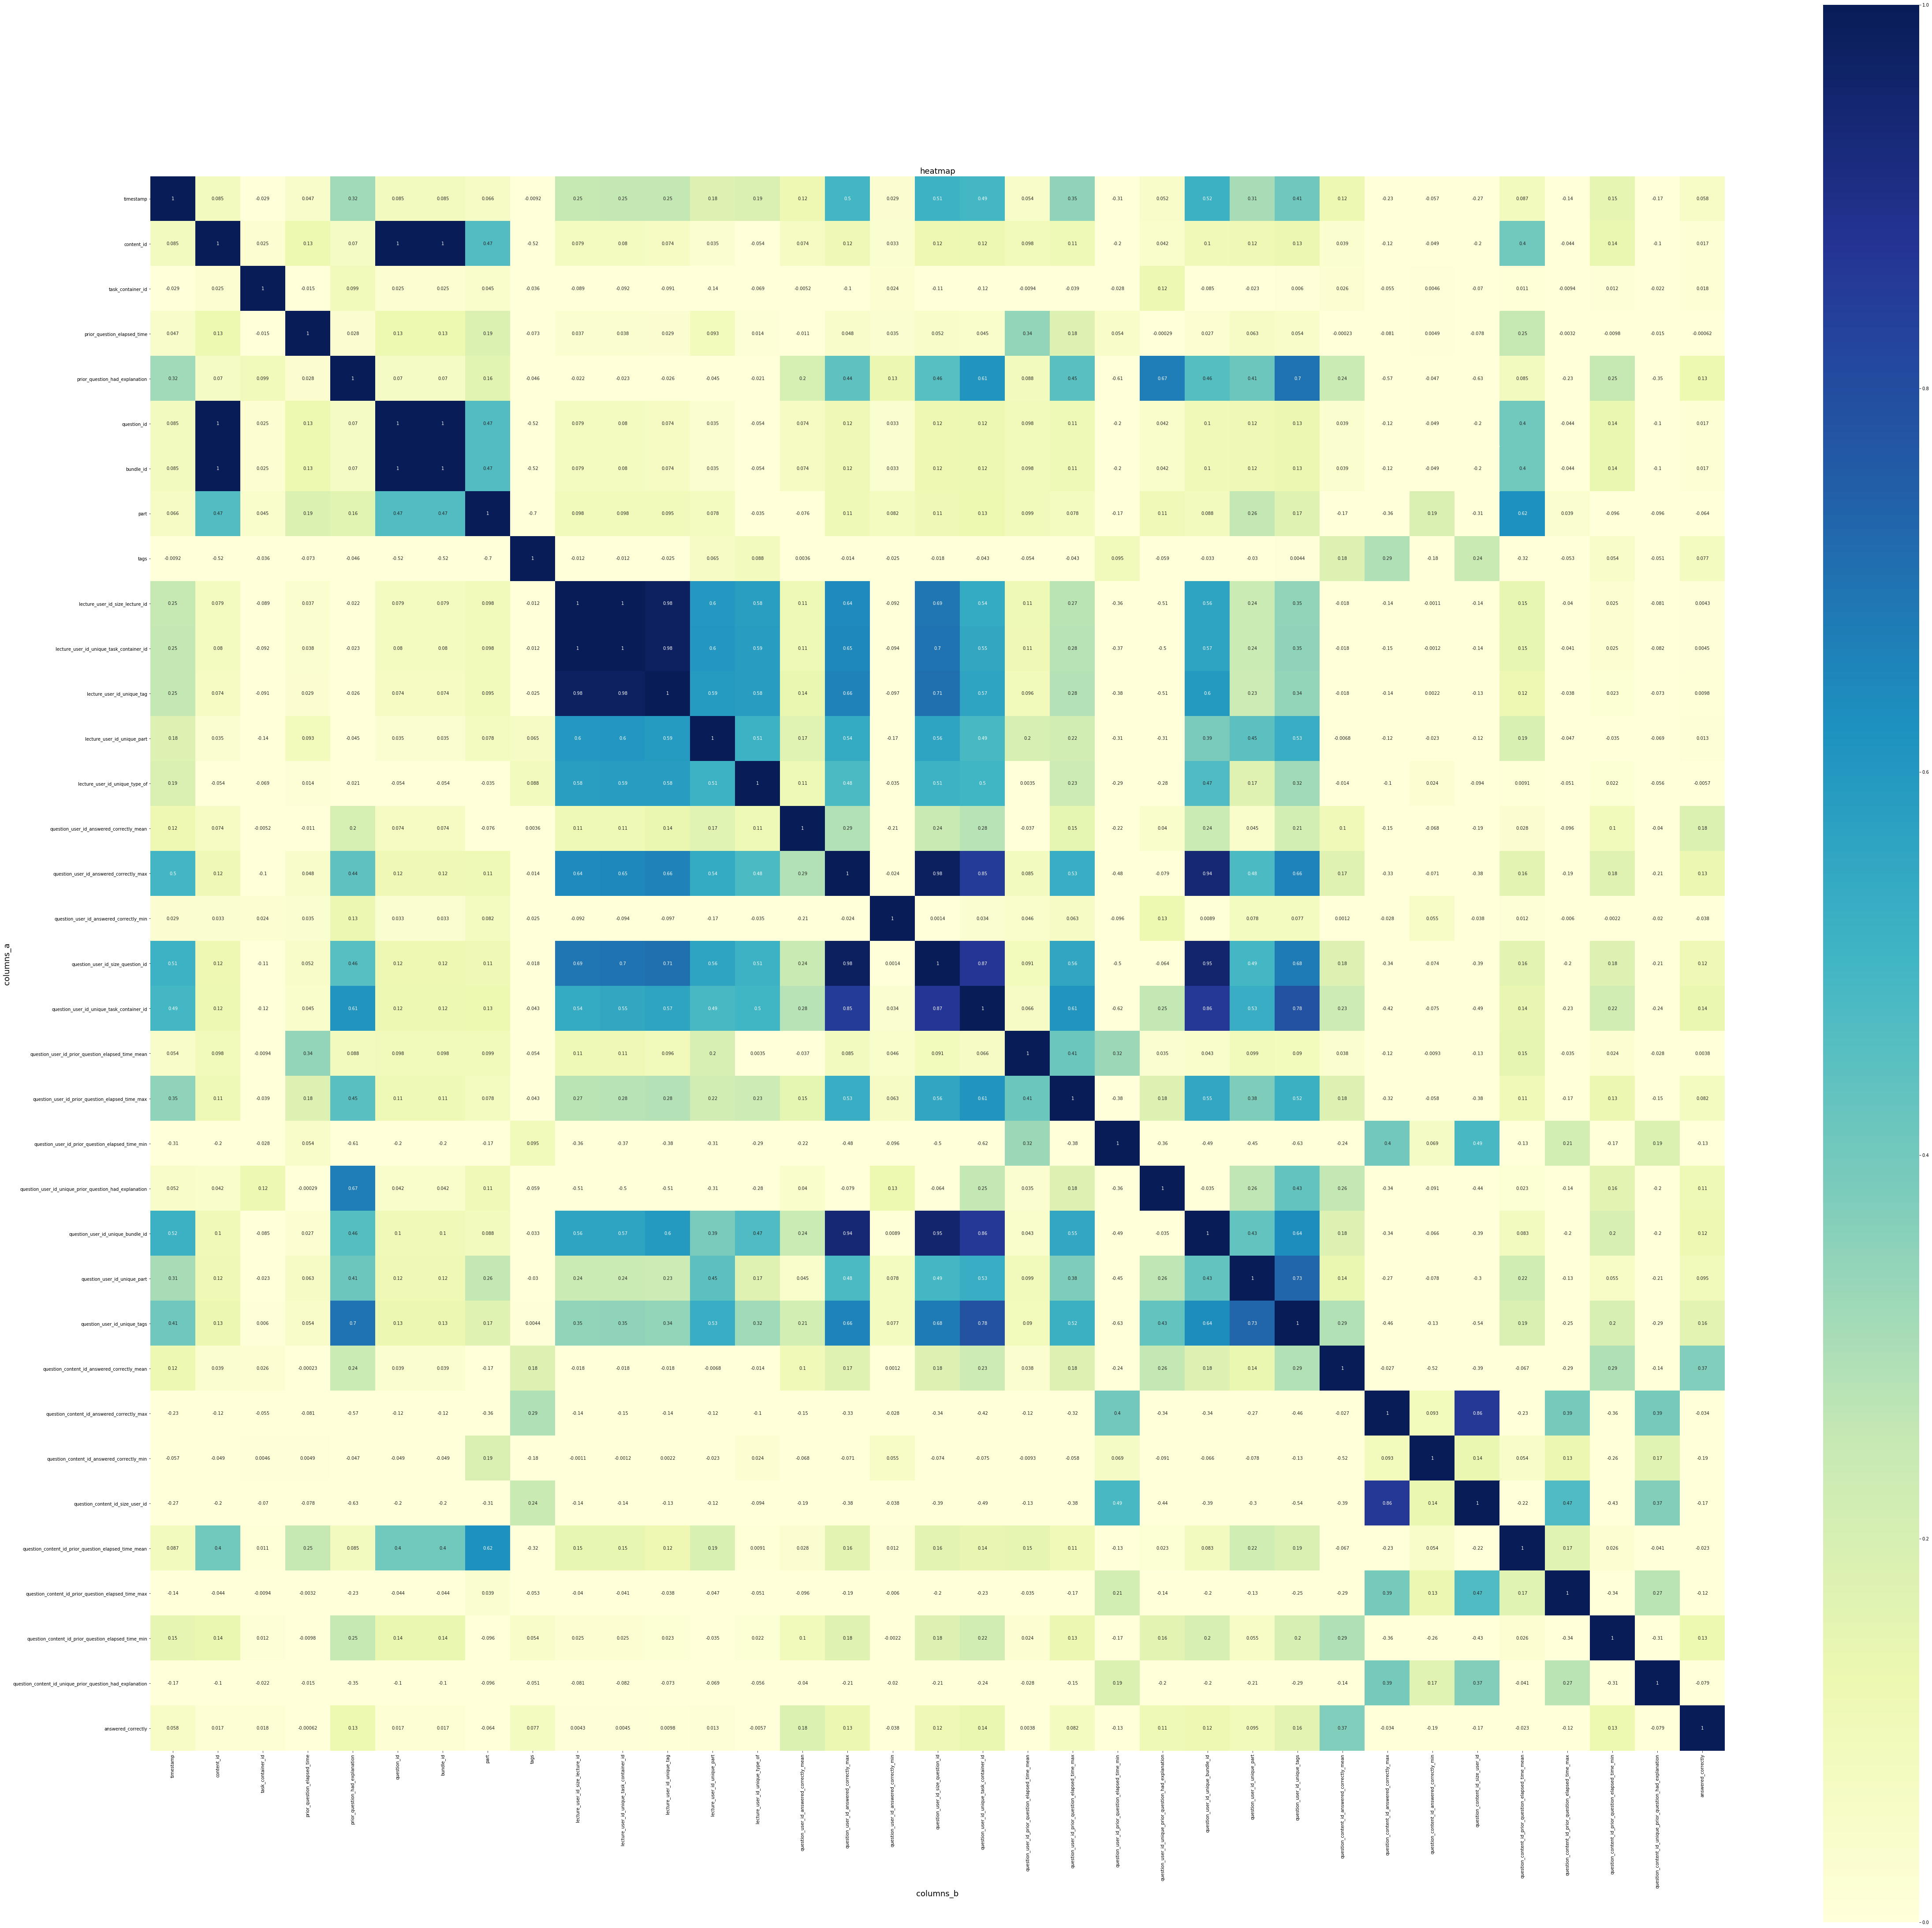

In [63]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (80,80))

sns.heatmap(train_data[features_columns + ['answered_correctly']].corr(), 
                annot=True, vmax=1,vmin = 0, xticklabels= True, yticklabels= True, square=True, cmap="YlGnBu")

ax.set_title('heatmap', fontsize = 18)
ax.set_ylabel('columns_a', fontsize = 18)
ax.set_xlabel('columns_b', fontsize = 18) 

特征重要性

In [64]:
X_test, y_test = valid_data[features_columns].values, valid_data['answered_correctly'].values

X_train, y_train = train_data[features_columns].values, train_data['answered_correctly'].values

In [65]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 9,
    'learning_rate': 0.3,
    'feature_fraction_seed': 2,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data': 20,
    'min_hessian': 1,
    'verbose': -1,
    'silent': 0
    }

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

gbm = lgb.train(
            params,
            lgb_train,
            num_boost_round=10000,
            valid_sets=lgb_eval,
            early_stopping_rounds=20
            )

/root/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1077: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[1]	valid_0's auc: 0.728893
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.742291
[3]	valid_0's auc: 0.744003
[4]	valid_0's auc: 0.746016
[5]	valid_0's auc: 0.746806
[6]	valid_0's auc: 0.747922
[7]	valid_0's auc: 0.748224
[8]	valid_0's auc: 0.748648
[9]	valid_0's auc: 0.749432
[10]	valid_0's auc: 0.749513
[11]	valid_0's auc: 0.749524
[12]	valid_0's auc: 0.750391
[13]	valid_0's auc: 0.750365
[14]	valid_0's auc: 0.750759
[15]	valid_0's auc: 0.75083
[16]	valid_0's auc: 0.750616
[17]	valid_0's auc: 0.750362
[18]	valid_0's auc: 0.75032
[19]	valid_0's auc: 0.750163
[20]	valid_0's auc: 0.749536
[21]	valid_0's auc: 0.749327
[22]	valid_0's auc: 0.749172
[23]	valid_0's auc: 0.748906
[24]	valid_0's auc: 0.748995
[25]	valid_0's auc: 0.749
[26]	valid_0's auc: 0.749123
[27]	valid_0's auc: 0.749233
[28]	valid_0's auc: 0.749106
[29]	valid_0's auc: 0.749448
[30]	valid_0's auc: 0.749557
[31]	valid_0's auc: 0.749593
[32]	valid_0's auc: 0.749658
[33]	valid_0's auc: 0.749

In [66]:
gbm.feature_importance()

array([ 2,  4,  1,  5,  0,  0,  1,  0,  0,  0,  0,  1,  0,  1, 28,  3, 14,
        1,  1,  5,  3,  3,  0,  2,  2,  0, 21,  3, 11,  3,  1,  2,  1,  1],
      dtype=int32)

In [67]:
len(features_columns)

34

In [71]:
gbm_features = pd.DataFrame({'feature_importance':gbm.feature_importance(),'feature_columns':features_columns}).sort_values(['feature_importance'],ascending=0)

In [72]:
gbm_features

,feature_importance,feature_columns
14,28,question_user_id_answered_correctly_mean
26,21,question_content_id_answered_correctly_mean
16,14,question_user_id_answered_correctly_min
28,11,question_content_id_answered_correctly_min
3,5,prior_question_elapsed_time
19,5,question_user_id_prior_question_elapsed_time_mean
1,4,content_id
29,3,question_content_id_size_user_id
27,3,question_content_id_answered_correctly_max
21,3,question_user_id_prior_question_elapsed_time_min


<Figure size 7200x7200 with 0 Axes>

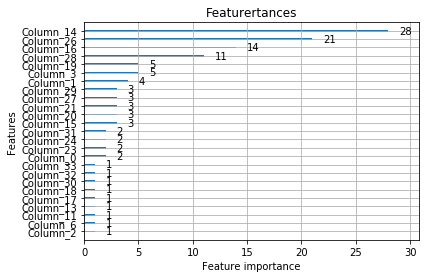

In [73]:
plt.figure(figsize=(100,100))
lgb.plot_importance(gbm, max_num_features=30)
plt.title("Featurertances")
plt.show()

交叉特征

In [74]:
X_test,y_test = valid_data[features_columns].values,valid_data['answered_correctly'].values
X_train,y_train = train_data[features_columns].values,train_data['answered_correctly'].values

In [75]:
epsilon=1e-5
func_dict = {
        'add': lambda x,y: x+y,
        'mins': lambda x,y: x-y,
        'div': lambda x,y: x/(y+epsilon),
        'multi': lambda x,y: x*y
        }

In [80]:
def cross_features(data,features_columns):
    df_cross_features = data.copy()
    for col_i in features_columns:
        for col_j in features_columns:
            for func_name, func in func_dict.items():
                col_func_features = '-'.join([col_i,func_name,col_j])
                df_cross_features[col_func_features] = func(data[col_i],data[col_j])
    return df_cross_features

In [81]:
train_cross_features = cross_features(train_data,features_columns)
test_cross_features = cross_features(valid_data,features_columns)

In [83]:
remove_columns = ['user_id','row_id','content_type_id','user_answer','answered_correctly','filter_row']
cross_features_columns = [c for c in train_cross_features.columns if c not in remove_columns]

In [ ]:
df_cross_features

In [85]:
X_test_cross, y_test_cross = test_cross_features[cross_features_columns].values, test_cross_features['answered_correctly'].values
X_train_cross, y_train_cross = train_cross_features[cross_features_columns].values, train_cross_features['answered_correctly'].values

In [86]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 9,
    'learning_rate': 0.3,
    'feature_fraction_seed': 2,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data': 20,
    'min_hessian': 1,
    'verbose': -1,
    'silent': 0
    }

lgb_train = lgb.Dataset(X_train_cross, y_train_cross)
lgb_eval = lgb.Dataset(X_test_cross, y_test_cross, reference=lgb_train)

gbm = lgb.train(
            params,
            lgb_train,
            num_boost_round=10000,
            valid_sets=lgb_eval,
            early_stopping_rounds=20
            )

/root/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1077: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[1]	valid_0's auc: 0.738852
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.744503
[3]	valid_0's auc: 0.745927
[4]	valid_0's auc: 0.747642
[5]	valid_0's auc: 0.748417
[6]	valid_0's auc: 0.749525
[7]	valid_0's auc: 0.750239
[8]	valid_0's auc: 0.75014
[9]	valid_0's auc: 0.750449
[10]	valid_0's auc: 0.75056
[11]	valid_0's auc: 0.750515
[12]	valid_0's auc: 0.750519
[13]	valid_0's auc: 0.750479
[14]	valid_0's auc: 0.750251
[15]	valid_0's auc: 0.749936
[16]	valid_0's auc: 0.749693
[17]	valid_0's auc: 0.749654
[18]	valid_0's auc: 0.749517
[19]	valid_0's auc: 0.749141
[20]	valid_0's auc: 0.74893
[21]	valid_0's auc: 0.748638
[22]	valid_0's auc: 0.748542
[23]	valid_0's auc: 0.748208
[24]	valid_0's auc: 0.748202
[25]	valid_0's auc: 0.748145
[26]	valid_0's auc: 0.748261
[27]	valid_0's auc: 0.747958
[28]	valid_0's auc: 0.748014
[29]	valid_0's auc: 0.747864
[30]	valid_0's auc: 0.747695
Early stopping, best iteration is:
[10]	valid_0's auc: 0.75056


In [87]:
gbm_cross_features = pd.DataFrame({'cross_feature_importance':gbm.feature_importance(),'cross_features_columns':cross_features_columns}).sort_values(['cross_feature_importance'],ascending=0)
gbm_cross_features

,cross_feature_importance,cross_features_columns
2042,9,question_user_id_answered_correctly_mean-add-q...
2045,5,question_user_id_answered_correctly_mean-multi...
3948,4,question_content_id_answered_correctly_min-div...
2084,2,question_user_id_answered_correctly_max-div-ta...
2052,2,question_user_id_answered_correctly_mean-div-q...
...,...,...
1559,0,lecture_user_id_unique_tag-mins-part
1558,0,lecture_user_id_unique_tag-add-part
1557,0,lecture_user_id_unique_tag-multi-bundle_id
1556,0,lecture_user_id_unique_tag-div-bundle_id


In [88]:
df_select = gbm_cross_features[gbm_cross_features['cross_feature_importance']>0]
df_select

,cross_feature_importance,cross_features_columns
2042,9,question_user_id_answered_correctly_mean-add-q...
2045,5,question_user_id_answered_correctly_mean-multi...
3948,4,question_content_id_answered_correctly_min-div...
2084,2,question_user_id_answered_correctly_max-div-ta...
2052,2,question_user_id_answered_correctly_mean-div-q...
...,...,...
28,1,question_content_id_answered_correctly_min
2040,1,question_user_id_answered_correctly_mean-div-q...
2924,1,question_user_id_prior_question_elapsed_time_m...
1200,1,tags-div-question_user_id_prior_question_elaps...


In [89]:
features_select = df_select['cross_features_columns'].to_list()
features_select

['question_user_id_answered_correctly_mean-add-question_content_id_answered_correctly_mean',
 'question_user_id_answered_correctly_mean-multi-question_content_id_answered_correctly_mean',
 'question_content_id_answered_correctly_min-div-question_content_id_answered_correctly_mean',
 'question_user_id_answered_correctly_max-div-task_container_id',
 'question_user_id_answered_correctly_mean-div-question_content_id_answered_correctly_min',
 'question_user_id_unique_task_container_id-multi-question_content_id_answered_correctly_mean',
 'question_user_id_unique_part-div-question_user_id_unique_bundle_id',
 'prior_question_elapsed_time-add-question_user_id_prior_question_elapsed_time_max',
 'question_user_id_unique_part-div-question_user_id_unique_tags',
 'question_user_id_size_question_id-add-question_user_id_prior_question_elapsed_time_min',
 'question_user_id_unique_part-multi-question_content_id_answered_correctly_mean',
 'question_user_id_prior_question_elapsed_time_min-multi-question_c

In [90]:
for i,_ in enumerate(features_select):
    cross_features_columns_i = features_select[:i]
    X_test_cross_i,y_test_cross_i = test_cross_features[cross_features_columns_i].values, test_cross_features['answered_correctly'].values
    X_train_cross_i,y_train_cross_i = train_cross_features[cross_features_columns_i].values,train_cross_features['answered_correctly'].values
    
    print('--------------------------')
    print('cross_features : ' + str(i))
    params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 9,
    'learning_rate': 0.3,
    'feature_fraction_seed': 2,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data': 20,
    'min_hessian': 1,
    'verbose': -1,
    'silent': 0
    }
    
    lgb_train = lgb.Dataset(X_train_cross_i,y_train_cross_i)
    lgb_eval = lgb.Dataset(X_test_cross_i,y_test_cross_i,reference=lgb_train)
    
    gbm = lgb.train(params,lgb_train,num_boost_round=10000,valid_sets=lgb_eval,early_stopping_rounds=20)
    print('cross_features : ' + str(i))
    print('--------------------------')

--------------------------
cross_features : 0
[1]	valid_0's auc: 0.5
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.5
[3]	valid_0's auc: 0.5
[4]	valid_0's auc: 0.5
[5]	valid_0's auc: 0.5
[6]	valid_0's auc: 0.5
[7]	valid_0's auc: 0.5
[8]	valid_0's auc: 0.5
[9]	valid_0's auc: 0.5
[10]	valid_0's auc: 0.5
[11]	valid_0's auc: 0.5
[12]	valid_0's auc: 0.5
[13]	valid_0's auc: 0.5
[14]	valid_0's auc: 0.5
[15]	valid_0's auc: 0.5
[16]	valid_0's auc: 0.5
[17]	valid_0's auc: 0.5
[18]	valid_0's auc: 0.5
[19]	valid_0's auc: 0.5
[20]	valid_0's auc: 0.5
[21]	valid_0's auc: 0.5
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5
cross_features : 0
--------------------------
--------------------------
cross_features : 1
[1]	valid_0's auc: 0.732895
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.737458
[3]	valid_0's auc: 0.737304
[4]	valid_0's auc: 0.738162
[5]	valid_0's auc: 0.738537
[6]	valid_0's auc: 0.738722
[7]	valid_0's auc: 

/root/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1077: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[17]	valid_0's auc: 0.738093
[18]	valid_0's auc: 0.737999
[19]	valid_0's auc: 0.73803
[20]	valid_0's auc: 0.737959
[21]	valid_0's auc: 0.737954
[22]	valid_0's auc: 0.737974
[23]	valid_0's auc: 0.737779
[24]	valid_0's auc: 0.737741
[25]	valid_0's auc: 0.737894
[26]	valid_0's auc: 0.737845
[27]	valid_0's auc: 0.737848
Early stopping, best iteration is:
[7]	valid_0's auc: 0.738914
cross_features : 1
--------------------------
--------------------------
cross_features : 2
[1]	valid_0's auc: 0.734969
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.73985
[3]	valid_0's auc: 0.739893
[4]	valid_0's auc: 0.740748
[5]	valid_0's auc: 0.741317
[6]	valid_0's auc: 0.741238
[7]	valid_0's auc: 0.741084
[8]	valid_0's auc: 0.741461
[9]	valid_0's auc: 0.741399
[10]	valid_0's auc: 0.741545
[11]	valid_0's auc: 0.741504
[12]	valid_0's auc: 0.741427
[13]	valid_0's auc: 0.741495
[14]	valid_0's auc: 0.741523
[15]	valid_0's auc: 0.741606
[16]	valid_0's auc: 0.741639
[17]	valid_0